In [1]:
import pandas as pd
import numpy as np

column_names = ['center_image', 'left_image', 'right_image', 'steering_angle', 'throttle', 'brake', 'speed']

In [2]:
from os.path import basename

def normalize_filepaths(dataframe, parent_filepath):
    for column in ['center_image', 'left_image', 'right_image']:
        dataframe[column] = dataframe[column].apply(lambda filepath: parent_filepath + basename(filepath))
    return dataframe

steering_correction = 0.07 # TODO link to either Slack channel or article

def steering_corrected_dataframe(dataframe, column, steering_correction):
    dataframe_copy = dataframe[[column, 'steering_angle']].copy()
    dataframe_copy['steering_angle'] = dataframe_copy['steering_angle'].apply(lambda angle: float(angle) + steering_correction)
    dataframe_copy.columns = ['center_image', 'steering_angle']
    return dataframe_copy

parent_directories = [
    'data/track1/forward/center', # TODO explain in the README that 'forward' & 'backward' mean counter-clockwise and clockwise around the track
    'data/track1/backward/center'
    #'data/track1/forward/leg1recovery',
    #'data/track1/forward/leg1turn1recovery',
    #'data/track1/forward/leg1hires',
    #'data/track1/forward/turn1',
    #'data/track1/forward/turn1apex',
    #'data/track1/forward/turn1end',
    #'data/track1/forward/leg1turn1bridge',
    #'data/track1/forward/turn1recovery',
    #'data/track1/forward/postbridgeturn'
]
training_dataframe = None
for parent_directory in parent_directories:
    dataframe = pd.read_csv(parent_directory + '/driving_log.csv', header=None, names=column_names, low_memory=False)
    left_image_steering_corrected = steering_corrected_dataframe(dataframe, 'left_image', steering_correction)
    right_image_steering_corrected = steering_corrected_dataframe(dataframe, 'right_image', -steering_correction)
    if type(training_dataframe) is pd.DataFrame:
        training_dataframe = pd.concat([training_dataframe, dataframe, left_image_steering_corrected, right_image_steering_corrected])
    else:
        training_dataframe = pd.concat([dataframe, left_image_steering_corrected, right_image_steering_corrected])

# Data Balance

In [3]:
for directory in parent_directories:
    !echo {directory} `ls -al {directory}/IMG | wc -l`

data/track1/forward/center 107058
data/track1/backward/center 128763


In [4]:
# shuffle training set for training / validation split
shuffled_training_dataframe = training_dataframe.sample(frac=1)
#shuffled_training_dataframe.head()

In [5]:
from sklearn.model_selection import train_test_split

training_samples, validation_samples = train_test_split(shuffled_training_dataframe)
#print(len(training_dataframe), len(training_samples), len(validation_samples))
training_samples = training_samples.reset_index(drop=True)
validation_samples = validation_samples.reset_index(drop=True)
#training_samples.head()

In [6]:
from keras.applications.vgg16 import VGG16
from keras.layers import BatchNormalization, Convolution2D, Dense, Dropout, ELU, Flatten, Input, Lambda
from keras.models import Model, Sequential
from keras.optimizers import Adam, Nadam
#from keras.regularizers import l1, l2, l1l2, activity_l1, activity_l2, activity_l1l2
import configparser

config = configparser.ConfigParser()
config.read('config.ini')

#pixels = 299
pixel_height = int(config['input_size']['height'])
pixel_width = int(config['input_size']['width'])
color_channels = 3
target_size = (pixel_height, pixel_width)
input_shape = (pixel_height, pixel_width, color_channels)

model = Sequential() # comma.ai
model.add(BatchNormalization(input_shape=input_shape))
#model.add(Lambda(lambda x: x/127.5 - 1., input_shape=input_shape))
model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
model.add(ELU())
model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
model.add(ELU())
model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
model.add(Flatten())
model.add(Dropout(.2))
model.add(ELU())
model.add(Dense(512))
model.add(Dropout(.5))
model.add(ELU())
model.add(Dense(1))
learning_rate = 1e-4
optimizer = Nadam() #Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='mse')

Using TensorFlow backend.


In [7]:
from keras.preprocessing.image import Iterator, load_img, img_to_array, flip_axis
#from keras.applications.vgg16 import preprocess_input
import cv2
from img_transformations import cropout_sky_hood
from PIL import Image, ImageEnhance

def translate(image, steering_angle):
    x_translation_range = 80
    x_translation = x_translation_range*np.random.uniform() - (x_translation_range / 2.0)
    steering_angle = steering_angle - (x_translation / x_translation_range * 2.0 * steering_correction)
    y_translation_range = 40
    y_translation = y_translation_range*np.random.uniform() - y_translation_range / 2.0
    transformation_matrix = (1, 0, x_translation, 0, 1, y_translation)
    transformed_img = image.transform(image.size, Image.AFFINE, transformation_matrix)
    
    return transformed_img, steering_angle

def brighten_or_darken(img, brightness_factor_min=0.25):
    enhancer = ImageEnhance.Brightness(img)
    random_factor = brightness_factor_min + np.random.uniform()
    enhanced_img = enhancer.enhance(random_factor)
    return enhanced_img

def shear(img, steering_angle, shearing_factor):
    return img, steering_angle

class DataframeIterator(Iterator):

    def __init__(self, dataframe, brightness_factor_min=None, translation=False, horizontal_flip=False,
                 target_size=(256, 256), color_mode='rgb',
                 dim_ordering='tf',
                 batch_size=32, shuffle=True, seed=None):

        self.dataframe = dataframe
        self.brightness_factor_min=brightness_factor_min
        self.translation = translation
        self.horizontal_flip = horizontal_flip
        self.target_size = tuple(target_size)
        if color_mode not in {'rgb', 'grayscale'}:
            raise ValueError('Invalid color mode:', color_mode,
                             '; expected "rgb" or "grayscale".')
        self.color_mode = color_mode
        self.dim_ordering = dim_ordering
        if dim_ordering == 'tf':
            self.channel_index = 3
            self.row_index = 1
            self.col_index = 2
            self.img_row_index = self.row_index - 1
            self.img_col_index = self.col_index - 1
            self.img_channel_index = self.channel_index - 1
        if self.color_mode == 'rgb':
            if self.dim_ordering == 'tf':
                self.image_shape = self.target_size + (3,)
            else:
                self.image_shape = (3,) + self.target_size
        else:
            if self.dim_ordering == 'tf':
                self.image_shape = self.target_size + (1,)
            else:
                self.image_shape = (1,) + self.target_size
        self.nb_sample = len(dataframe)
        super(DataframeIterator, self).__init__(self.nb_sample, batch_size, shuffle, seed)

    def next(self):
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
        # The transformation of images is not under thread lock so it can be done in parallel
        batch_x = np.zeros((current_batch_size,) + self.image_shape)
        batch_y = np.zeros(current_batch_size)
        # build batch of image data
        for i, j in enumerate(index_array):
            current_dataframe = self.dataframe.iloc[j]
            image_filepath = current_dataframe['center_image'].strip() # NOTE: parameterize column name
            img = load_img(image_filepath)#, target_size=self.target_size)
            
            if self.brightness_factor_min:
                img = brighten_or_darken(img, self.brightness_factor_min)
            
            y = current_dataframe['steering_angle']
            if self.translation:
                img, y = translate(img, y)
            
            img = cropout_sky_hood(img)
            
            img = img.resize((self.target_size[1], self.target_size[0]))
            
            x = img_to_array(img, dim_ordering=self.dim_ordering)
            
            if self.horizontal_flip:
                if np.random.random() < 0.5:
                    x = flip_axis(x, self.img_col_index)
                    y = -y # flip steering angle when we horizontally flip image
            batch_x[i] = x #preprocess_input(x)
            batch_y[i] = y
        return batch_x, batch_y

batch_size = 256
brightness_factor_min = 0.25
training_generator = DataframeIterator(training_samples, 
                                       brightness_factor_min=brightness_factor_min,
                                       translation=True,
                                       horizontal_flip=True, 
                                       target_size=target_size, 
                                       batch_size=batch_size)
validation_generator = DataframeIterator(validation_samples, 
                                         target_size=target_size, 
                                         batch_size=batch_size, 
                                         shuffle=False)
#test_generator = DataframeIterator(test_samples, target_size=target_size, batch_size=batch_size, shuffle=False)
#training_generator.next()

# Test Image Transformations

steering angle 0.08997131


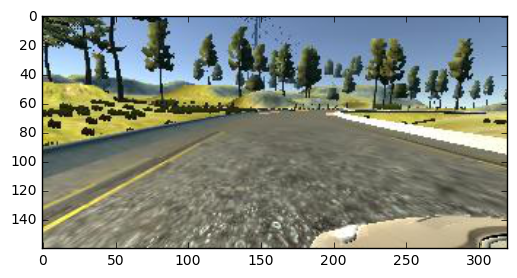

In [8]:
%matplotlib inline

from matplotlib.pyplot import imshow

test_sample =  training_samples.sample(1).iloc[0]
test_img_filepath = test_sample['center_image'].strip()
steering_angle = test_sample['steering_angle']
print('steering angle', steering_angle)
img = load_img(test_img_filepath)#, target_size=self.target_size)
imshow(img)

translated steering angle 0.0909703347424


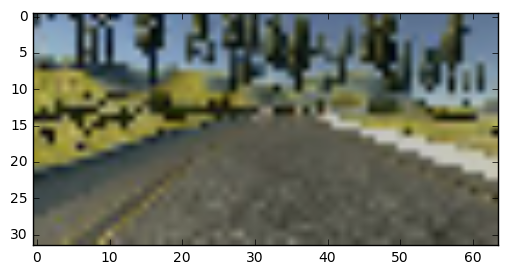

In [9]:
img, steering_angle = translate(img, steering_angle)
#imshow(img)
img = brighten_or_darken(img, brightness_factor_min)
img = cropout_sky_hood(img)
print('translated steering angle', steering_angle)
img = img.resize((pixel_width, pixel_height))
imshow(img)

# Training

In [10]:
max_epochs = 8

In [11]:
#training_generator = generate_from_dataframe(training_samples)
training_samples_count = len(training_samples)
#validation_generator = generate_from_dataframe(validation_samples)
validation_samples_count = len(validation_samples)
#next(training_generator)
#test_samples_count = len(test_samples)

In [12]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [13]:
# resume training
#model.load_weights('model.h5')

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=2, verbose=1)
model_checkpoint = ModelCheckpoint(filepath='comma.model.weights.{epoch:02d}-{val_loss:.5f}.h5', verbose=1, save_best_only=True, save_weights_only=True)
learning_rate_plateau_reducer = ReduceLROnPlateau(verbose=1, patience=0, epsilon=1e-5)
model.fit_generator(training_generator, training_samples_count, # account for: horizontal flipping, x-translation range
                    max_epochs, 
                    callbacks=[model_checkpoint, learning_rate_plateau_reducer, early_stopping],
                    validation_data=validation_generator, 
                    nb_val_samples=validation_samples_count)

Epoch 1/8
176861/176861 [==============================] - 542s - loss: 0.1317 - val_loss: 0.0070
Epoch 2/8
176861/176861 [==============================] - 474s - loss: 0.0098 - val_loss: 0.0062
Epoch 3/8
176861/176861 [==============================] - 475s - loss: 0.0088 - val_loss: 0.0057
Epoch 4/8
176861/176861 [==============================] - 475s - loss: 0.0080 - val_loss: 0.0047
Epoch 5/8
176861/176861 [==============================] - 475s - loss: 0.0073 - val_loss: 0.0043
Epoch 6/8
176861/176861 [==============================] - 476s - loss: 0.0065 - val_loss: 0.0042
Epoch 7/8
176861/176861 [==============================] - 476s - loss: 0.0060 - val_loss: 0.0041
Epoch 8/8
176861/176861 [==============================] - 483s - loss: 0.0055 - val_loss: 0.0032


In [14]:
#model.save_weights('model.h5')

In [7]:
import json

model_json_string = model.to_json()
with open('model.json', 'w') as outfile:
    json.dump(model_json_string, outfile)

# Testing...

In [10]:
#model.load_weights('model.h5')

In [12]:
model.evaluate_generator(test_generator, test_samples_count) 
#0.0010745568868129561 
#0.0014838234640777231
#0.0028282808319534665
#0.0059747247878073019
#0.0031086671844570411
#0.0053260803041177314

0.015796573778202965

# Inspect Worst Predictions

In [12]:
test_predictions = model.predict_generator(test_generator, test_samples_count)

In [13]:
test_predictions

array([[-0.03155801],
       [-0.03315222],
       [-0.03006131],
       ..., 
       [-0.02560698],
       [-0.02625413],
       [-0.02782261]], dtype=float32)

In [13]:
len(test_predictions)

14985

In [14]:
len(test_samples)

14985

In [15]:
print(test_predictions.shape, test_samples['steering_angle'].as_matrix().shape)

(14985, 1) (14985,)


In [16]:
actual_steering_angles = test_samples['steering_angle'].as_matrix().reshape((len(test_samples), 1))

In [17]:
errors = test_predictions - actual_steering_angles

In [18]:
indices_sorted_by_error = np.argsort(errors, axis=0)
indices_sorted_by_error

array([[10442],
       [10440],
       [10441],
       ..., 
       [ 8313],
       [ 8361],
       [ 8360]])

In [19]:
leftmost_error_index, rightmost_error_index = indices_sorted_by_error[0], indices_sorted_by_error[-1]
print(errors[leftmost_error_index], errors[rightmost_error_index])

[[-0.40696913]] [[ 0.57563611]]


In [20]:
test_samples.iloc[leftmost_error_index]

,center_image,left_image,right_image,steering_angle,throttle,brake,speed
10442,data/track1/forward/center/IMG/center_2016_12_...,data/track1/forward/center/IMG/left_2016_12_11...,data/track1/forward/center/IMG/right_2016_12_1...,0.312714,0.12181,0,12.2937


In [21]:
test_predictions[leftmost_error_index]

array([[-0.09425513]], dtype=float32)

<class 'numpy.ndarray'>


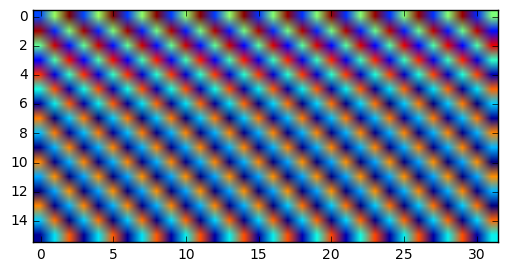

In [28]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

img = mpimg.imread(test_samples.iloc[leftmost_error_index]['center_image'].iloc[0])
print(type(img))
plt.imshow(np.resize(img, (16, 32)))